# Predicting Churn For a Major Ride Sharing Company in San Francisco

This notebook outlines the process used to predict churn for a ride-sharing company from San Francisco. The purpose was to not only predict churn but use a model that allowed for interpretation of the features in order to adjust marketing in the future. The company as well as the cities have been redacted. For comments, questions, or suggestions please contact me, Mickey, at michaelhmulder@gmail.com.





## Import all libraries and functions used in this project


In [1]:
import pandas as pd  
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler, RobustScaler
import churn_cleaning as cc
import seaborn as sns
import visuals as viz
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA
# from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist, squareform
from sklearn.manifold import TSNE
from sklearn.ensemble import AdaBoostClassifier

## Cleaning and Data Exploration

Load data into a Pandas a dataframe


In [2]:
df = pd.read_csv("data/churn_train.csv")

Awesome lets look at the data and see what is going on:

In [3]:
print (df.info())
print (df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 12 columns):
avg_dist                  40000 non-null float64
avg_rating_by_driver      39838 non-null float64
avg_rating_of_driver      33472 non-null float64
avg_surge                 40000 non-null float64
city                      40000 non-null object
last_trip_date            40000 non-null object
phone                     39681 non-null object
signup_date               40000 non-null object
surge_pct                 40000 non-null float64
trips_in_first_30_days    40000 non-null int64
luxury_car_user           40000 non-null bool
weekday_pct               40000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 3.4+ MB
None
           avg_dist  avg_rating_by_driver  avg_rating_of_driver     avg_surge  \
count  40000.000000          39838.000000          33472.000000  40000.000000   
mean       5.791302              4.777434              4.601697      1.074

Alright 40,000 entries, that allows us to use most models, it may make clustering a bit difficult but for the most part this does not rule out any models. Looks like were missing some data from both sets of rating and what type of phone the customer used. Lets take a look at some sample data:


In [4]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,6.94,5.0,5.0,1.00,Astapor,2014-05-03,Android,2014-01-12,0.0,0,False,100.0
1,8.06,5.0,5.0,1.00,Astapor,2014-01-26,Android,2014-01-25,0.0,2,True,0.0
2,21.50,4.0,NaN,1.00,Winterfell,2014-05-21,iPhone,2014-01-02,0.0,1,True,100.0
3,9.46,5.0,NaN,2.75,Winterfell,2014-01-10,Android,2014-01-09,100.0,1,False,100.0
4,13.77,5.0,NaN,1.00,Winterfell,2014-05-13,iPhone,2014-01-31,0.0,0,False,100.0


Okay so looks like the phones are either Android or iPhone so most likely the NaN values are probably some sort of other device, maybe a computer, a blackberry or something else. Before we get to far lets create some dummy variables, do a bit of cleaning:

In [5]:
df['last_trip_date']=pd.to_datetime(df['last_trip_date'])
df['signup_date']=pd.to_datetime(df['signup_date'])
df['churn']= np.where(df['last_trip_date'] >= '2014-06-01',0,1)
df['phone']= np.where(df['phone'] == 'Android', 'Android', np.where(df['phone'] == 'iPhone',
            'iPhone', np.where(df['phone'] == 'test', 'test','Other')))
df['avg_rating_by_driver'] =df['avg_rating_by_driver'].fillna(4.777)
df['avg_rating_of_driver'] =df['avg_rating_of_driver'].fillna(4.602)
df = pd.get_dummies(df, prefix = ['city'], columns= ['city'])
df = pd.get_dummies(df, prefix = ['phone'], columns= ['phone'])
df = pd.get_dummies(df, prefix = ['luxury_car_user'], columns= ['luxury_car_user'], drop_first=True)
df.drop(['last_trip_date'], inplace=True, axis = 1)

Alright lets recap: above we converted the 'last_trip_date' and 'signup_date' to datetime objects for analysis. Then we created a variable churn where customers that are active (have had a ride in the last month- '2014-06-01' to '2014-07-01') equal zero and nonactive customers equal 1. We then converted any of the NaN values in 'phone' to 'Other'. Finally, we created dummies for the 'city', 'phone', and 'luxury_car_used' columns and dropped the 'last_trip_date' column so we don't suffer data leakage.

**Note:** In the cleaning_func function in churn_cleaning.py we imputed the NaN values for all ratings using the whole data set mean as we also have a completely separate test data csv and we opted to use the mean of the entire train csv and not the train_test split. Because we will eventually run this data against that test data we will use the mean for the entire data set. If we were to initially start with the entire dataset we would impute the mean from only the train split of the dataset. 

Let's take another look at the data:

In [6]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,signup_date,surge_pct,trips_in_first_30_days,weekday_pct,churn,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_Other,phone_iPhone,luxury_car_user_True
0,6.94,5.0,5.000,1.00,2014-01-12,0.0,0,100.0,1,1,0,0,1,0,0,0
1,8.06,5.0,5.000,1.00,2014-01-25,0.0,2,0.0,1,1,0,0,1,0,0,1
2,21.50,4.0,4.602,1.00,2014-01-02,0.0,1,100.0,1,0,0,1,0,0,1,1
3,9.46,5.0,4.602,2.75,2014-01-09,100.0,1,100.0,1,0,0,1,1,0,0,0
4,13.77,5.0,4.602,1.00,2014-01-31,0.0,0,100.0,1,0,0,1,0,0,1,0


Before we run our split we might as well add some features that might help to explain the labels. Lets add the following columns:

* days_since_signup
* diff_ratings

and drop the 'signup date' column.

In [7]:
cleaned_df = df.copy()
cleaned_df['days_since_signup']=(pd.to_datetime('2014-07-01') - cleaned_df['signup_date']).dt.days
cleaned_df['diff_ratings']= cleaned_df['avg_rating_of_driver']-cleaned_df['avg_rating_by_driver']
cleaned_df.drop(['signup_date'], inplace=True, axis = 1)

Once again lets take a look at the data:

In [8]:
cleaned_df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,churn,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_Other,phone_iPhone,luxury_car_user_True,days_since_signup,diff_ratings
0,6.94,5.0,5.000,1.00,0.0,0,100.0,1,1,0,0,1,0,0,0,170,0.000
1,8.06,5.0,5.000,1.00,0.0,2,0.0,1,1,0,0,1,0,0,1,157,0.000
2,21.50,4.0,4.602,1.00,0.0,1,100.0,1,0,0,1,0,0,1,1,180,0.602
3,9.46,5.0,4.602,2.75,100.0,1,100.0,1,0,0,1,1,0,0,0,173,-0.398
4,13.77,5.0,4.602,1.00,0.0,0,100.0,1,0,0,1,0,0,1,0,151,-0.398


Alright now that we've done some cleaning lets split the data! Remember had we not had a separate test dataset that we would have imputed the rating means from only the train splits and applied those values to the test value NaNs. As we will find out shortly the labels are not evenly distributed as a result we will stratify the y_column so that we have an equal proportion of labels in both the test and train splits.

In [9]:
y_clean = cleaned_df.pop('churn')
X_clean = cleaned_df
X_train, X_test, y_train, y_test = train_test_split(X_clean,y_clean, stratify = y_clean)

In [10]:
X_train.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_Other,phone_iPhone,luxury_car_user_True,days_since_signup,diff_ratings
2301,9.25,4.9,4.1,1.00,0.0,9,100.0,0,1,0,0,0,1,0,174,-0.8
36424,8.08,4.7,4.8,1.02,6.5,8,71.0,0,0,1,0,0,1,1,164,0.1
10297,9.20,4.8,5.0,1.00,0.0,0,25.0,0,0,1,0,0,1,1,153,0.2
2268,2.23,5.0,5.0,1.00,0.0,3,33.3,0,0,1,0,0,1,0,173,0.0
29281,1.68,4.5,5.0,1.00,0.0,2,0.0,1,0,0,0,0,1,1,171,0.5


Now that we some cleaned and split data lets run some quick visualizations. Seaborn has some great visualizations so lets take advantage of that. 

The first we will use is a scatterplot matrix, with this many features and datapoints it will be difficult to get any minute features but we will see what we can pull out. 

The second plot is a violin plot. A violin plot helps to show us the spread and density of each value in the feature space. 

**Note:** 'Viz' is my personal library of visualizations, some of these functions can be found in the attached python script





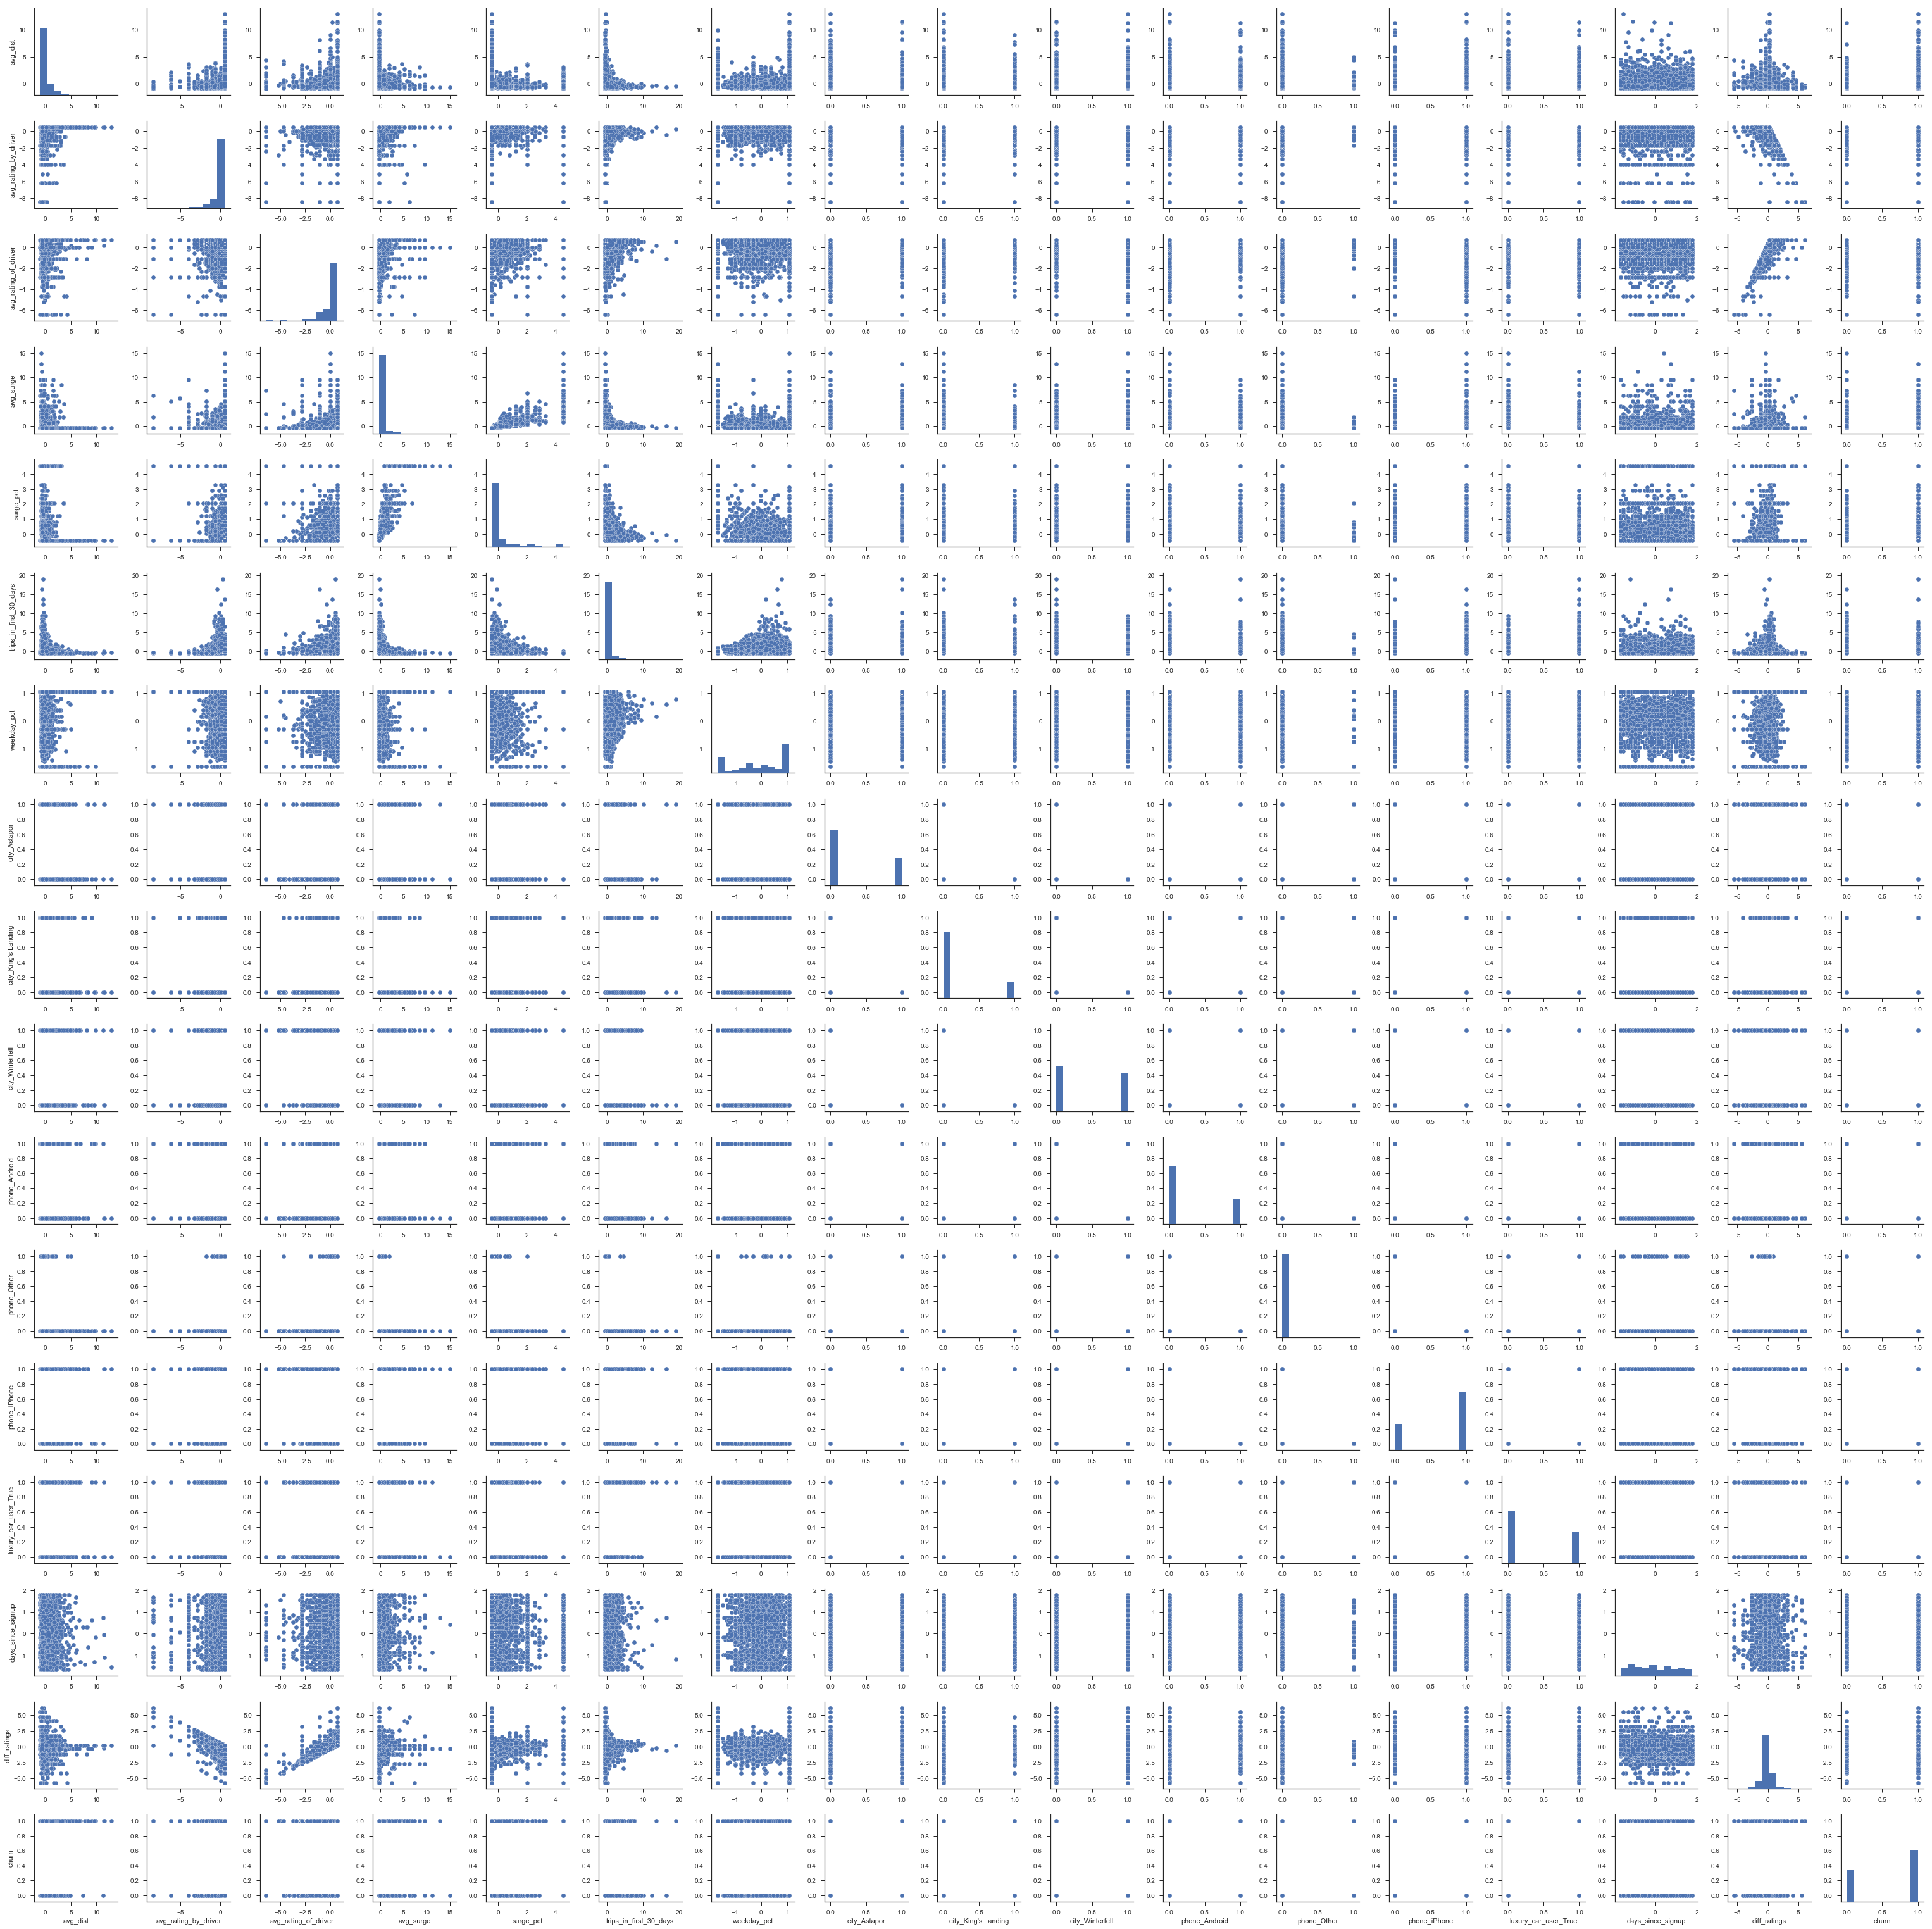

In [34]:
complete_train = pd.concat([X_train, y_train], axis = 1)
viz.seaborn_scatterplot_df(complete_train)

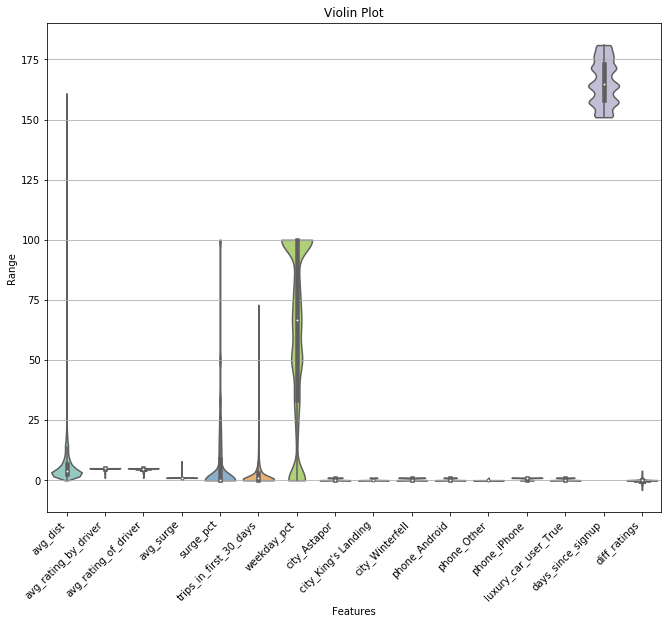

In [12]:
viz.Violin_Plot(X_train)

Wow! There is a lot going on here! Lets break down that scatterplot. Well one key takeaway is that churn is not evenly split, looks like we have a about 35% Active (Churn = 0) users and 65% Non-Active users(Churn = 1). There might be some other trends here, it looks like surge might have some sort of trend but it is too early to tell. 

Now for the violin plot, wow there are certainly some outliers, we will definitely want to standardize this data. Let's use a standard scaler and see if this violin plot cleans up.

**Note:** We only want to scale the non categorical data, a robust scaler was tried as well but preformed somewhat similarly

In [31]:
scaler = StandardScaler()
X_col_names = X_train.columns
y_col_names = ['churn']
X_train_df = pd.DataFrame(X_train, columns = X_col_names)
X_test_df = pd.DataFrame(X_test, columns = X_col_names)
y_train_df = pd.DataFrame(y_train, columns = y_col_names)
y_test_df = pd.DataFrame(y_test, columns = y_col_names)
column_list = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver',
                   'avg_surge', 'surge_pct', 'trips_in_first_30_days',
                   'weekday_pct', 'days_since_signup', 'diff_ratings']

X_train_df[column_list] = scaler.fit_transform(X_train_df[column_list])
X_test_df[column_list] = scaler.transform(X_test_df[column_list])

Lets run that violin plot again:

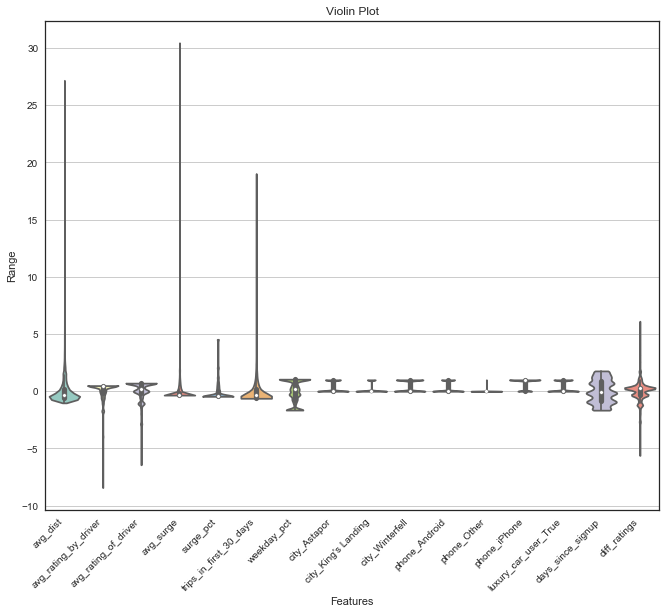

In [32]:
viz.Violin_Plot(X_train_df)

Wow! Even when standard deviations are plotted there are still some strong outliers! for the sake of visualizing this a little better lets restrict the y-axis to +/- 5 standard deviations

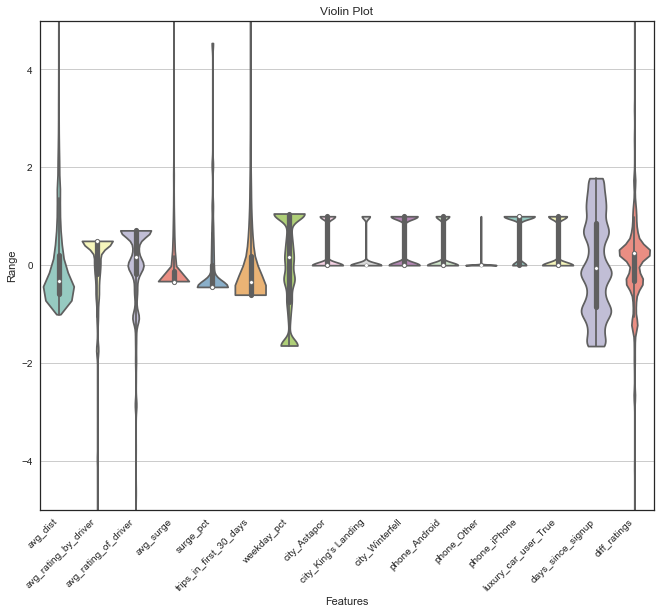

In [33]:
viz.Violin_Plot(X_train_df, scaled=True)

Now we're talking! Let's work through this, there are predominantly shorter rides, the average ratings of driver and by driver are generally pretty high with a couple lower ratings. Generally the surge amount is small but there are a couple that are extremely higher. The majority of users only have a few rides in the first thirty days, some have a really high amount. Weekday_pct is interesting, it looks like there is a group of users that predominantly drive over the weekend and a group that is predominantly during the weekday. The categorical features I'll leave up to the reader to think about. The last two columns appear to have three major groupings, this is interesting, perhaps there was some promotion that caused users to signup more frequently at specific timepoints. The ratings difference is interesting as well, we may want to explore why there are three groups. 

Let's create a correlation matrix to see if any features are correlated.

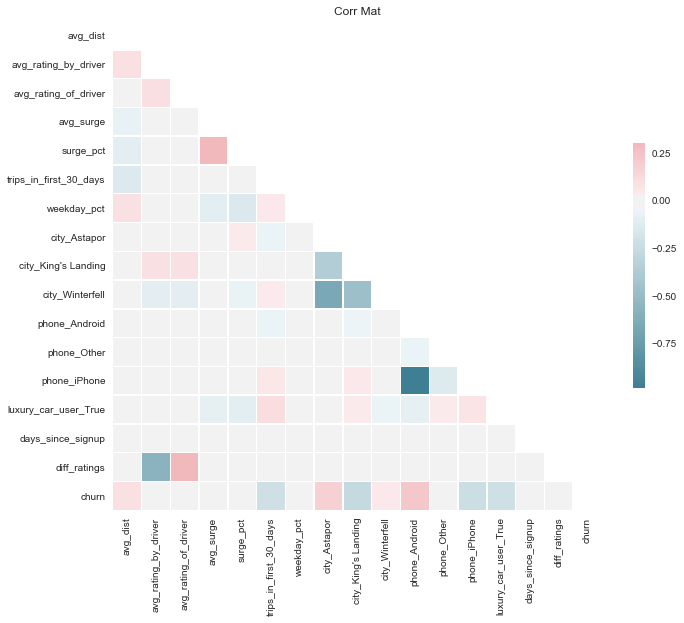

In [16]:
complete_train_scaled = pd.concat([X_train_df, y_train_df], axis = 1)

viz.create_corr_mat(complete_train_scaled, 'Corr Mat')

Alright progress! Right off the bat it looks like churn is correlated with being in the city of Astapor or Winterfell, having an Android and average distance. Churn is inversely correlated with rides in first 30 days, riding in King's Landing, using an iPhone, and using a luxury car. 

Other notes some other variables are highly correlated, we should pay attention to these depending on what model we finally select. 
* Surge percent and average surge (unsurprising)
* Whether a user is an android or iPhone user (unsurprising)
* Which city a user is in (unsurprising)

## Explore dimension reduction

**READ THIS**
This code stopped executing properly when I updated python to 3.6.4, I have to explore why this is the case the error from scikit learn is that the initial matrix (X_train_df) can not have infinites or NaN's our function does not. It runs fine in 2.7. 

Let's start with a PCA analysis, to determine if we can reduce features to an important subset. A Scree Plot will show if certain linear combinations of features can be used to describe the data. Although this potentially reduces the interpretability of the model it may allow us to determine if one or two features are solely responsible for predicting churn. 



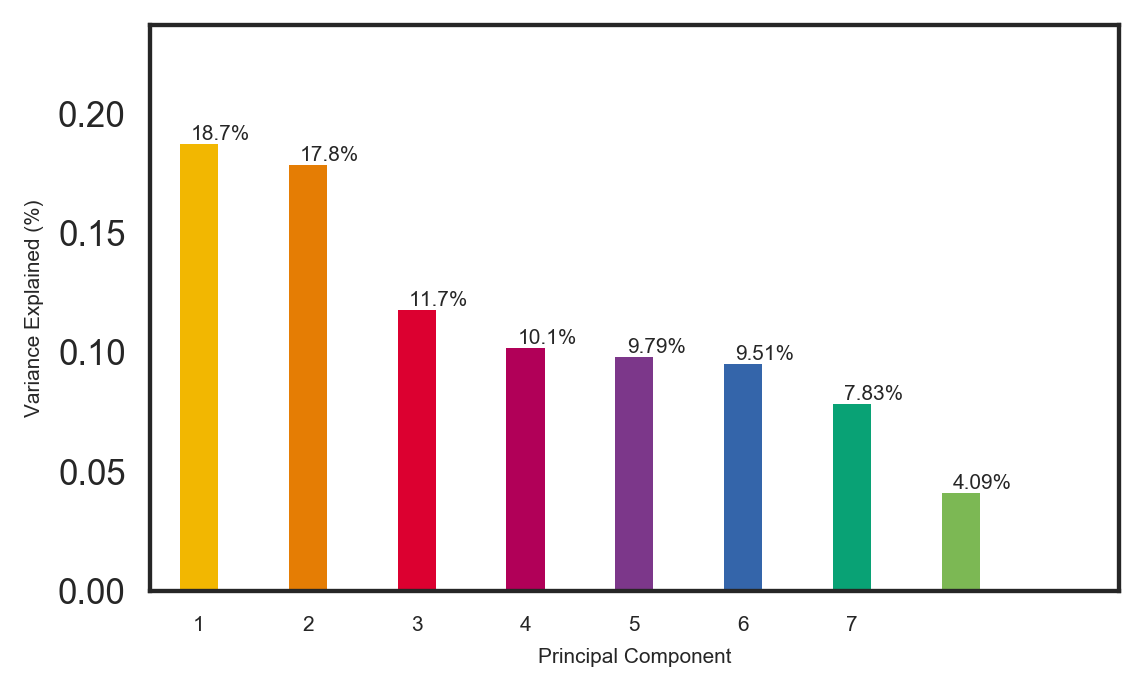

In [17]:
pca = PCA(n_components = 8)
transform_mat = pca.fit_transform(X_train_df)
viz.scree_plot(pca)
plt.show()

Alright it looks like there is no distinct elbow in the scree plot, this suggests that there is not really a strong dimension reduced subset of a data. Lets plot just the first two axes, with the label as the point.

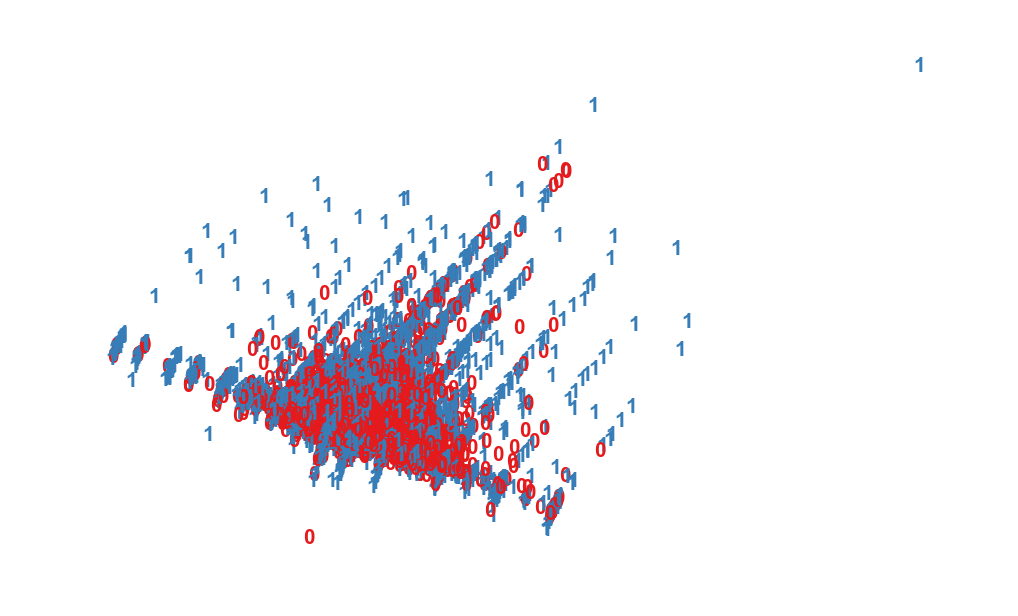

In [18]:
viz.plot_embedding(transform_mat, y_train_df.values)
plt.show()

There is no clear groupings when the top two dimensions are plotted in PCA. TSNE was also conducted there did not appear to be any clustering. This is a very slow process as a result only a subset of 5000 samples was used.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.016s...
[t-SNE] Computed neighbors for 5000 samples in 0.778s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.747498
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.891701
[t-SNE] Error after 500 iterations: 1.534182


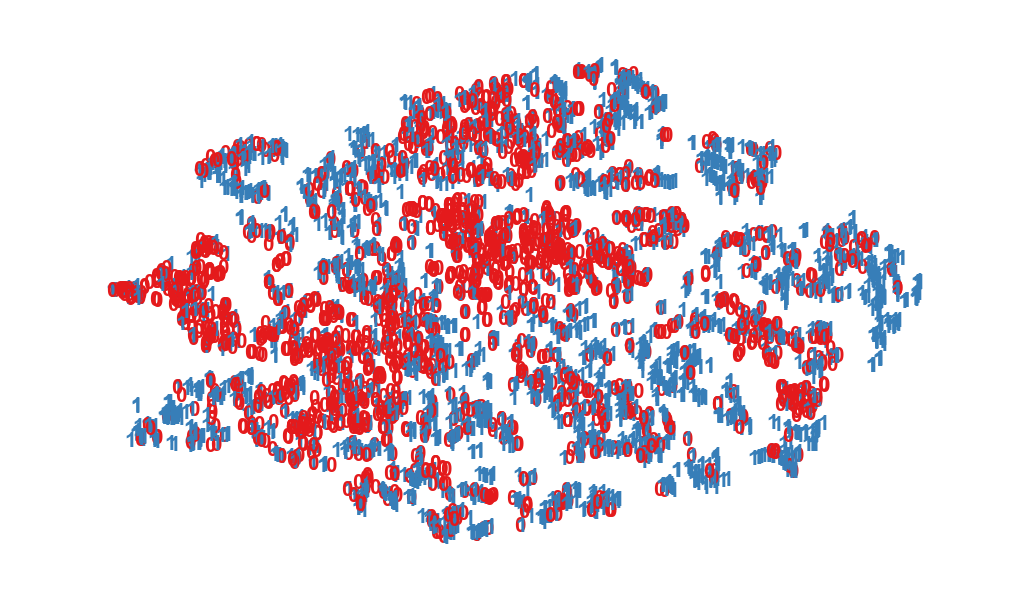

In [19]:
tsne = TSNE(n_components = 2, verbose = 1, n_iter=500)
transform_mat = tsne.fit_transform(X= X_train_df[:5000])
viz.plot_embedding(transform_mat, y_train_df.values[:5000])
plt.show()

Well unfortunately it does not appear that there is any obvious way to reduce the features by combining them. Although this was a good exercise, it was not particularly useful to this dataset.

## Modeling

We chose to use an F-score as a way to measure predictions as there is a bit of class imbalance in the labels. Alternatively we could have used SMOTE or other sampling methods to balance the data. We then run through numerous vanilla (scikit-learn default hyper parameters) models to determine the best vanilla model. We used a logistic regression as a baseline that we should be able to beat.

The models tested include:
* Logistic Regression
* Random Forest
* AdaBoostClassifier
* XGBoost (Must have separate packages installed as a result commented out, it performed similarly to gradient boosting trees)
* GradientBoostingClassifier
* SVC (kernel='poly', degree = 3)

In [35]:
logistic = LogisticRegression()
rand_forest = RandomForestClassifier()
ada_boost = AdaBoostClassifier()
grb_boost = GradientBoostingClassifier()
# XGB_boost = XGBClassifier()
svc = SVC(kernel='poly', degree = 3)

method_list = [logistic,
              rand_forest,
              ada_boost,
              grb_boost,
              #XGB_boost,
              svc]

In [36]:

for model in method_list:
    model.fit(X_train_df.values, np.ravel(y_train_df))
    test_predict = model.predict(X_test_df)
    print('{0} Precision: {1:0.3f}'.format(model.__class__.__name__, precision_score(y_test_df, test_predict)))
    print('{0} Recall: {1:0.3f}'.format(model.__class__.__name__, recall_score(y_test_df, test_predict)))
    print('{0} F1: {1:0.3f}'.format(model.__class__.__name__, f1_score(y_test_df, test_predict)))

LogisticRegression Precision: 0.733
LogisticRegression Recall: 0.849
LogisticRegression F1: 0.787
RandomForestClassifier Precision: 0.806
RandomForestClassifier Recall: 0.791
RandomForestClassifier F1: 0.799
AdaBoostClassifier Precision: 0.802
AdaBoostClassifier Recall: 0.862
AdaBoostClassifier F1: 0.831
GradientBoostingClassifier Precision: 0.806
GradientBoostingClassifier Recall: 0.864
GradientBoostingClassifier F1: 0.834
SVC Precision: 0.764
SVC Recall: 0.881
SVC F1: 0.818


Well it looks like the gradient boosting trees have the best F1 score at 0.832, the AdaBoost and SVM methods came in a close second and third. SVM is interesting to explore here but will likely be harder to explain later. As a result we will continue with gradient boosting trees. A neural net would also be interesting here, but coupled potentially complicate feature importance later. Although certain tree methods are resilient to covariation we should try and drop some of the covariate features and run the models again.

In [37]:
col_2_drop = ['avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge', 'city_Astapor', 'phone_iPhone']
X_train_reduced = X_train_df.drop(col_2_drop, axis = 1)
X_test_reduced = X_test_df.drop(col_2_drop, axis = 1)

for model in method_list:
    model.fit(X_train_reduced.values, np.ravel(y_train_df))
    test_predict = model.predict(X_test_reduced)
    print('{0} Precision: {1:0.3f}'.format(model.__class__.__name__, precision_score(y_test_df, test_predict)))
    print('{0} Recall: {1:0.3f}'.format(model.__class__.__name__, recall_score(y_test_df, test_predict)))
    print('{0} F1: {1:0.3f}'.format(model.__class__.__name__, f1_score(y_test_df, test_predict)))

LogisticRegression Precision: 0.733
LogisticRegression Recall: 0.849
LogisticRegression F1: 0.787
RandomForestClassifier Precision: 0.804
RandomForestClassifier Recall: 0.788
RandomForestClassifier F1: 0.796
AdaBoostClassifier Precision: 0.791
AdaBoostClassifier Recall: 0.866
AdaBoostClassifier F1: 0.827
GradientBoostingClassifier Precision: 0.794
GradientBoostingClassifier Recall: 0.867
GradientBoostingClassifier F1: 0.829
SVC Precision: 0.715
SVC Recall: 0.922
SVC F1: 0.805


Looks like gradient boosting is still the best model, the recall is slightly better bet the precision isn't quite as good as before. Because those variables are highly correlated the model does not lose much information from dropping  those features, so lets go with the simpler model. What is interesting is just how high the SVC recall is, it might be worth exploring down the road. 

## Grid Search and Model Tuning

We used scikit learns buit in grid search to screen hyper parameters. Basically this tests every possibility of a combination of hyper parameters with cross validation and returns the best features. This example is broken into two gridsearches a more thorough but time consuming process would test all parameters at once.  This can be a timely process so be patient.

In [23]:
gbc = GradientBoostingClassifier()
parameters = {'learning_rate': [0.01, 0.1, 1], 
              'max_features' : [7, 9, None],
              'max_depth' : [3, 5, 7],
              'loss' : ['exponential', 'deviance']}
clf = GridSearchCV(gbc, parameters, n_jobs = 7, verbose=1, scoring = 'f1', cv = 5) # I have 8 processors, for other computers change this appropriately
clf.fit(X_train_reduced, np.ravel(y_train_df))
print (clf.best_score_)
print (clf.best_params_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   28.7s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:  2.7min
[Parallel(n_jobs=7)]: Done 270 out of 270 | elapsed:  4.1min finished


0.837281342632
{'max_features': 7, 'loss': 'deviance', 'learning_rate': 0.1, 'max_depth': 5}


In [24]:
gbc = GradientBoostingClassifier()
parameters = {'learning_rate': [clf.best_params_['learning_rate']], 
              'n_estimators': [100, 250], 
              'subsample':[0.7, 0.8, 0.9], 
              'min_samples_leaf' : [7, 9, 15],
              'max_features' : [clf.best_params_['max_features']],
              'max_depth' : [clf.best_params_['max_depth']],
              'loss' : [clf.best_params_['loss']]}
clf2 = GridSearchCV(gbc, parameters, n_jobs = 7, verbose=1, scoring = 'f1', cv = 5) # I have 8 processors, for other computers change this appropriately
clf2.fit(X_train_reduced, np.ravel(y_train_df))
print (clf2.best_score_)
print (clf2.best_params_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:   35.3s
[Parallel(n_jobs=7)]: Done  90 out of  90 | elapsed:  1.6min finished


0.838401339113
{'loss': 'deviance', 'learning_rate': 0.1, 'min_samples_leaf': 15, 'n_estimators': 250, 'subsample': 0.9, 'max_features': 7, 'max_depth': 5}



The best model shown above had the following hyperparameters:

| Hyperparameter | Value | Intuition
| :--------------| :---: |:--------
|learning_rate   |  0.1  | The learning rate effects the gradient descent, lower allows for a slower but more accurate descent
|n_estimators    |  250  | The number of boosting stages, higher is often better, but time consuming
|subsample       |  0.9  | Numbers less than one add a bit of stochasticity in the gradient descent
|min_samples_leaf|   15  | Minimum number of samples required to create a leaf
|max_features    |   7   | The number of features to look at when splitting
|max_depth       |   5   | The max depth of a tree, how many times a tree can split
|loss        |deviance| The loss function



## Feature Importance and Discussion

Great! The gridsearch worked, now we have to actually look at the model and determine not only what features are important but why they are important. For this we can use a feature importance graph as well as partial dependency plots.

Here is the ROC curve, it helps to show the balance between the true positive rate and the false positive rate.

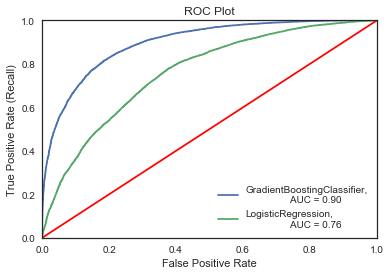

In [25]:
gbc = GradientBoostingClassifier(learning_rate= clf2.best_params_['learning_rate'], 
                                 n_estimators = clf2.best_params_['n_estimators'], 
                                 subsample= clf2.best_params_['subsample'], 
                                 max_features = clf2.best_params_['max_features'], 
                                 max_depth = clf2.best_params_['max_depth'], 
                                 loss = clf2.best_params_['loss'], 
                                 min_samples_leaf = clf2.best_params_['min_samples_leaf'])
lrc = LogisticRegression()

viz.roc_curve(X_train_reduced, np.ravel(y_train_df), [gbc, lrc]);

The ROC plot certainly shows an improvement over the logistic regression. it may also be more beneficial to use a threshold of 0.4 (instead of 0.5) to classify potential churn customers. This is because it is likely that the cost of losing a customer is more expensive than additional marketing and deals that might allow them to stay.


The feature importance plot helps us to determine which features are the most important to split on in the tree method. As a result we can determine which features most strongly contribute to churn. 

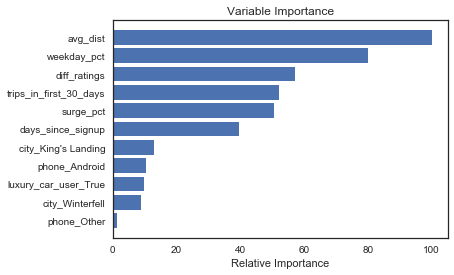

In [26]:
viz.feature_importance_plot(X_train_reduced, np.ravel(y_train_df), gbc)

This plot shows that there are 6 features that the model predominantly splits on. 
* The average distance of the ride
* The percent of rides taken during the weekday
* The difference in ratings between the rider and driver
* The number of trips in the first 30 days
* The average surge percentage
* Days since signup

To actually determine how these features effect churn and in which direction they move we have to use partial dependency plots.

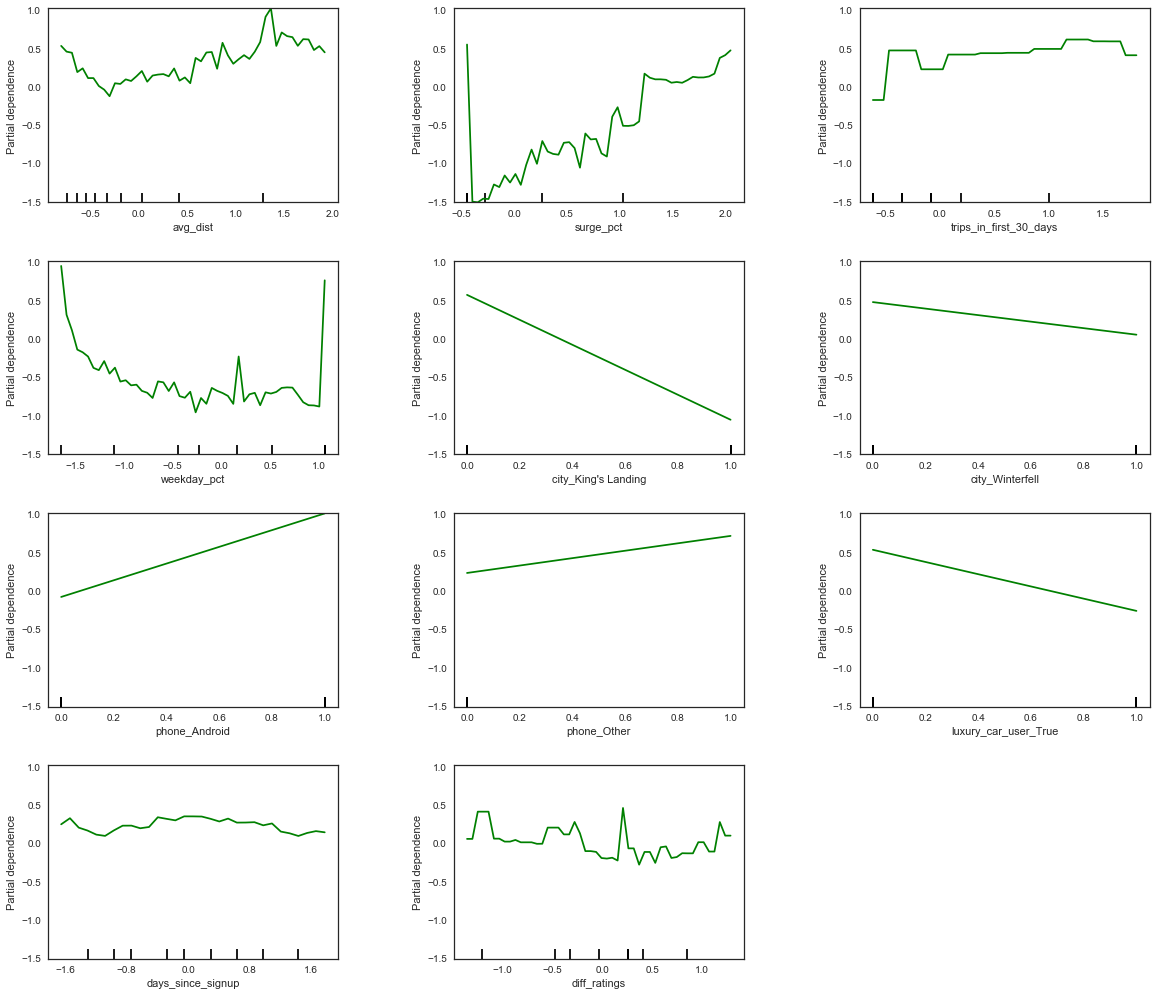

In [27]:

viz.partial_dependency_plots(X_train_reduced, np.ravel(y_train_df), gbc);

Using these plots we can determine how each of our top 6 features effect the likelihood of churn. These plots represent essentially the derivative of churn with respect to each variable. As a result a value less than zero, means that as the feature increases churn decreases, a number greater than zero means that churn increases as the variable increases.

|Feature|Description|
|-------|-----------|
|Avg. Dist | At either really short or really long rides people are more likely to churn, generally though, the longer the ride the more likely to churn
|Weekday Percentage| When people user the service on only weekends or weekdays they are more likely to churn|
|Diff in Rating | If there is a difference in rating between the driver and rider there is a higher likelihood to churn|
|Number of trips in first 30 days | The more trips people took in the first 30 days, the more likely they are to churn|
|Average Surge Percentage | As average surge increases the change in churn increases
| Days since sign up | Basically all this says is that the longer a customer is a member, the more likely they are to no longer to be active. The rate appears to be constant



## Unseen data

Lets see how are model runs on completely unseen data.


In [28]:
#fit model on training data
gbc.fit(X_train_reduced.values, np.ravel(y_train_df));

In [29]:

#import data
df_test_data = pd.read_csv("data/churn_test.csv")
#cleaning
df_test_data['last_trip_date']=pd.to_datetime(df_test_data['last_trip_date'])
df_test_data['signup_date']=pd.to_datetime(df_test_data['signup_date'])
df_test_data['churn']= np.where(df_test_data['last_trip_date'] >= '2014-06-01',0,1)
df_test_data['phone']= np.where(df_test_data['phone'] == 'Android', 'Android', np.where(df_test_data['phone'] == 'iPhone',
            'iPhone', np.where(df_test_data['phone'] == 'test', 'test','Other')))
df_test_data['avg_rating_by_driver'] =df_test_data['avg_rating_by_driver'].fillna(4.777)
df_test_data['avg_rating_of_driver'] =df_test_data['avg_rating_of_driver'].fillna(4.602)
df_test_data = pd.get_dummies(df_test_data, prefix = ['city'], columns= ['city'])
df_test_data = pd.get_dummies(df_test_data, prefix = ['phone'], columns= ['phone'])
df_test_data = pd.get_dummies(df_test_data, prefix = ['luxury_car_user'], columns= ['luxury_car_user'], drop_first=True)
df_test_data.drop(['last_trip_date'], inplace=True, axis = 1)
#feature engineering
cleaned_df_test = df_test_data.copy()
cleaned_df_test['days_since_signup']=(pd.to_datetime('2014-07-01') - cleaned_df_test['signup_date']).dt.days
cleaned_df_test['diff_ratings']= cleaned_df['avg_rating_of_driver']-cleaned_df_test['avg_rating_by_driver']
cleaned_df_test.drop(['signup_date'], inplace=True, axis = 1)
# pop churn
y_clean_test = cleaned_df_test.pop('churn')
X_clean_test = cleaned_df_test
#scale data according to trained scaler
X_clean_test[['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
       'surge_pct', 'trips_in_first_30_days', 'weekday_pct',
       'days_since_signup','diff_ratings']] = scaler.transform(X_clean_test[['avg_dist',
       'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
       'surge_pct', 'trips_in_first_30_days', 'weekday_pct',
       'days_since_signup','diff_ratings']])
col_2_drop = ['avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge', 'city_Astapor', 'phone_iPhone']
X_reduced_test = X_clean_test.drop(col_2_drop, axis = 1)



In [30]:
#run test model
test_predict = gbc.predict(X_reduced_test)
print('{0} Precision: {1:0.3f}'.format(model.__class__.__name__, precision_score(y_clean_test, test_predict)))
print('{0} Recall: {1:0.3f}'.format(model.__class__.__name__, recall_score(y_clean_test, test_predict)))
print('{0} F1: {1:0.3f}'.format(model.__class__.__name__, f1_score(y_clean_test, test_predict)))

GradientBoostingClassifier Precision: 0.810
GradientBoostingClassifier Recall: 0.848
GradientBoostingClassifier F1: 0.828


Not too bad! The scores aren't quite as high as the train data, which is expected. There might be a little overfitting but not much as the F1 score and Recall are still quite high.

## Recommendations

### Recommendations
* Offer discounts to people who normally use the service only on weekends and weekdays for the alternative time period
* Generally do not offer discounts to those who you luxury cars
* Create ‘surge immunity’ or flat-fares subscription membership for people that have a high percentages of surge trips or longer distances
    * AB Testing
* Offer a bonus program to people who on average have a high surge percentage, maybe something like ‘surge immunity’ for the next couple rides

### Other Musings
* It is interesting that as people have more trips in the first 30 days they are more likely to churn, we would like to explore that more. Maybe a signup promotion isn't as effective as expected
* It is possible and likely that when someone is a high percentage user for the weekends or weekdays, they may just have had very few trips. It would be beneficial to look at total trips if the data had been available.
